In [4]:
import pandas as pd
import numpy as np
#
# Population data to rows of region name, population in 2000, population in 2001, ..., population in 2022
#

# population 2012-2022
# encoding: currently transforms all ä's and ö's to ïŋ―
population = pd.read_csv('./data/raw/PKS_Vaestoennusteet_2013_2022.csv', delimiter=';', encoding='iso8859_10')

# subset for only helsinki's larger areas (suurpiiri)
hel = population[population['Kunta/City'].str.contains('Helsinki')]
hel = population[population['Alue/District'].str.contains('suurpiiri')]

# subset only Alue/District and populations per year
unnecessary_columns = ['Kunta/City', 'Aluetaso/Regional Level', 'Seutukarttakoodi/Map code', 'Ikïŋ―/Age']
hel = hel.drop(unnecessary_columns, axis=1)
# drop population before 2015
hel = hel.drop(hel.columns[1:16], axis=1)

# populations per year are strings, cast to int
def map_to_int(val):
    if val == '.': # missing values marked with .
        return None
    
    return int(val)

for i in range(15,23): # years 2000-2023
    year = '0'+ str(i) if i < 10 else str(i) 
    hel['20'+year] = hel['20' + year].map(map_to_int)

#sum populations per area (originally population per age group)
hel_per_area = hel.groupby('Alue/District').first()

#hel_per_area.to_csv('./data/silver/past_population_clean.csv')

In [5]:
#
# Population 2023-2036 data cleaning
#

# read data
df = pd.read_csv('./data/raw/population.csv', encoding='iso8859-10')

# fix indexing
df = df.reset_index()
# years are in format '2022 Perusvaihtoehto <year_number>'. Remove uselss prefix
true_column_names = df[0:1].values.tolist()[0]
string_form_columns = true_column_names[0:3]
year_column_names   = list(map(lambda name: int(name.split()[-1]), true_column_names[3:]))
columns = string_form_columns + year_column_names

df = df.set_axis(columns, axis='columns') # fix column index
df = df.drop(0, axis=0) # drop row containing indices

# subset for greater areas
df = df[df['Alue'].str.contains('suurpiiri')]

# remove unnecessary columns
unnecessary_years = range(2012,2023)
unnecessary_columns = list(unnecessary_years) + ['Äidinkieli', 'Ikä']

df = df.drop(unnecessary_columns, axis=1)
df = df.set_index('Alue') # remove numeric row index

df.to_csv('./data/silver/future_population_clean.csv')


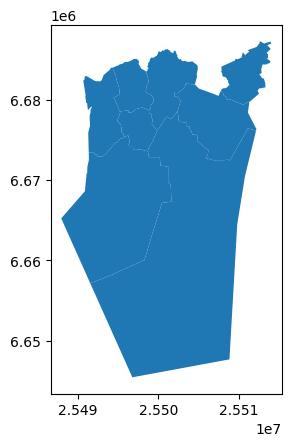

In [6]:
#
# Shapes for greater regions in Helsinki area. To do: categorize building data based on these areas
#

# geopandas for the regions
import geopandas as gpd 

# note: also shx file required for this to work!
greater_regions = gpd.read_file('./data/raw/suurpiirit_WFS_areas.shp')
plot = greater_regions.plot()

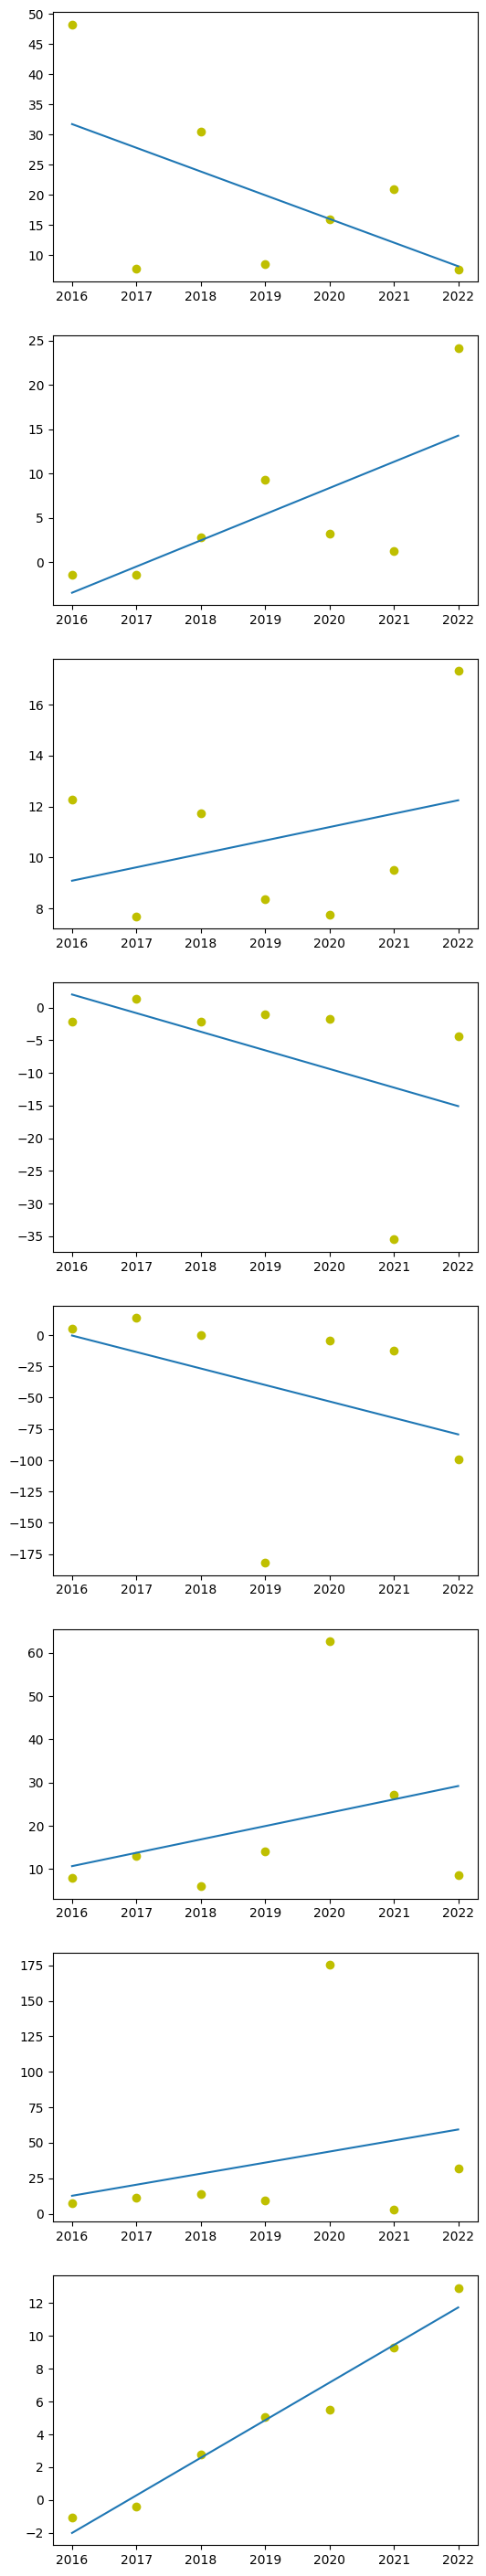

In [7]:
# ML stuff
from sklearn import linear_model

np.random.seed(1)

# Combine population data to one dataframe
df_future = pd.read_csv( './data/silver/future_population_clean.csv')
df_past   = pd.read_csv('./data/silver/past_population_clean.csv')
df_population = pd.concat([df_past, df_future], axis=1)
df_population = df_population.drop('Alue', axis=1)

# Find change in population per greater area 2016-2036
diff = df_population.drop('Alue/District', axis=1).diff(axis=1)
diff = pd.concat([df_population['Alue/District'], diff], axis=1)
diff = diff.drop(['2015'], axis=1)

# Find amount of apartments built per greater area 2013-2036
# mock data 
import numpy as np

apartments = pd.DataFrame(np.random.randint(1,200,(8,7))) # this should be new apartments per area (8 areas) per year (7 years, 2016-2022)
years_2016_to_2022 = np.linspace(2016,2022, 7, dtype=int)
apartments.columns = years_2016_to_2022 
apartments['District'] = diff['Alue/District']
apartments.set_index('District', inplace=True)

# Simple linear regression per area for evolution of people / new apartment
diff_past = diff.drop([str(year) for year in range(2023,2037)], axis=1) 

linear_models = list()
ys = list()
X = years_2016_to_2022.reshape((-1,1))


for index, area in diff_past.iterrows():
    area_population_changes = np.array(area.drop('Alue/District'))
    area_apartments_built = np.array(apartments.iloc[[index]])[0]
    y = area_population_changes / area_apartments_built # evolution of average people per new apartment
    ys.append(y) # for plotting
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    linear_models.append(regr)

# Plot regression results to double-check
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(8,1)
fig.set_size_inches(6,36)

for i, model in enumerate(linear_models):
    y_pred = [model.predict([year])[0] for year in X ]
    
    ax[i].plot(X, ys[i], 'yo') # yo for round label
    ax[i].plot(X,y_pred)



In [9]:
X

array([[2016],
       [2017],
       [2018],
       [2019],
       [2020],
       [2021],
       [2022]])

In [10]:
y

array([-1.0909090909090908, -0.4155844155844156, 2.7777777777777777,
       5.0754716981132075, 5.481481481481482, 9.272727272727273,
       12.913793103448276], dtype=object)

In [8]:

# Forecast: population change after 2023 -> apartments needed per greater area
X_pred = np.linspace(2023,2036, 14, dtype=int)
diff_future = diff.drop([str(year) for year in range(2016,2023)], axis=1) 

# Results dataframe: rows are areas & columns are years
forecasts = pd.DataFrame(np.zeros((8,14)))
forecasts.set_index(apartments.index, inplace=True)
forecasts.columns = X_pred

for i, model in enumerate(linear_models):
    forecasted_people_per_apartment = model.predict(X_pred.reshape(-1,1))
    pop_change_future_in_area = np.array(diff_future.iloc[i].drop('Alue/District')).reshape(14)
    apartment_demand = pop_change_future_in_area / forecasted_people_per_apartment
    forecasts.iloc[i] = apartment_demand

forecasts.to_csv('forecasts.csv')